In [2]:
# Import of modules
import os
import argparse

import numpy as np
from numpy import zeros, newaxis

import dicom
from dicom.dataset import Dataset
from dicom.dataset import FileDataset
import datetime
import time
import platform
import natsort
import glob

import nibabel as nib
import nibabel.orientations as orientations

import sys
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib import image as imsave
from IPython import display


D:\ProgramData\Anaconda3\envs\dicom_dbg\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [3]:
# Globals (for now)
IMG_DTYPE = np.float
SEG_DTYPE = np.uint8
MASK_DTYPE = np.uint16

plt.set_cmap('gray')

<Figure size 432x288 with 0 Axes>

In [4]:
# Image I/O
def read_dicom_series(directory, filepattern = "image_*"):
    """ Reads a DICOM Series files in the given directory.
    Only filesnames matching filepattern will be considered"""
    if not os.path.exists(directory) or not os.path.isdir(directory):
        raise ValueError("Given directory does not exist or is a file : " + str(directory))
    print('\tRead Dicom dir: ' + str(directory))
    lstFilesDCM = natsort.natsorted(glob.glob(os.path.join(directory, filepattern)))
    print('\tLength dicom series: ' + str(len(lstFilesDCM)))
    # Get ref file
    RefDs = dicom.read_file(lstFilesDCM[0])
    # Load dimensions based on the number of rows, columns, and slices (along the Z axis)
    ConstPixelDims = (int(RefDs.Rows), int(RefDs.Columns), len(lstFilesDCM))
    # The array is sized based on 'ConstPixelDims'
    ArrayDicom = np.zeros(ConstPixelDims, dtype=RefDs.pixel_array.dtype)
    Arrayds = [None] * len(lstFilesDCM)

    # loop through all the DICOM files
    b = 0
    m = 1
    for filenameDCM in lstFilesDCM:
        # read the file
        ds = dicom.read_file(filenameDCM)
        # store the raw image data
        ArrayDicom[:, :, lstFilesDCM.index(filenameDCM)] = ds.pixel_array
        Arrayds[lstFilesDCM.index(filenameDCM)] = ds
        # DICOM type 1 required
        b = float(ds[0x0028, 0x1052].value)  # 0028,1052  Rescale Intercept: -1024
        m = float(ds[0x0028, 0x1053].value)  # 0028,1053  Rescale Slope: 1

    return ArrayDicom, Arrayds, len(lstFilesDCM), b, m

# The following has some errors when you try to re-read it.
def write_dicom_mask(img_slice, ds_slice, slice_no, outputdirectory, filepattern = ".dcm"):
    file_meta = Dataset()
    #will need to generate all UID  uniqely see Mayo Image Studio
    # file_meta.MediaStorageSOPClassUID = 'Secondary Capture Image Storage'
    # file_meta.MediaStorageSOPInstanceUID = '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    # file_meta.ImplementationClassUID = '1.3.6.1.4.1.9590.100.1.0.100.4.0'
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
    file_meta.MediaStorageSOPInstanceUID = "1.2.3"
    file_meta.ImplementationClassUID = "1.2.3.4"
    
    series_number = ds_slice[0x0020, 0x0011].value
    base_fname = str(slice_no).zfill(6)
    filename = outputdirectory + os.path.sep + base_fname + "_" + str(series_number) + "_mask1" + filepattern
    ds = FileDataset(filename, {}, file_meta=file_meta, preamble=b"\0" * 128)
    
    ds.ImplementationVersionName = "1.2.3.4"
    
    ds.PatientName = ds_slice.PatientName
    ds.PatientID = ds_slice.PatientID
    
    # Set the transfer syntax
    ds.is_little_endian = True
    ds.is_implicit_VR = True
    ds.file_meta.TransferSyntaxUID = dicom.UID.ImplicitVRLittleEndian
   
    # Set creation date/time
    ds.StudyDate = ds_slice[0x0008, 0x0020].value
    ds.StudyTime = ds_slice[0x0008, 0x0030].value
    
    dt = datetime.datetime.now()
    ds.ContentDate = dt.strftime('%Y%m%d')
    timeStr = dt.strftime('%H%M%S.%f')  # long format with micro seconds
    ds.ContentTime = timeStr

    ds.Modality = ds_slice.Modality
    ds.StudyInstanceUID = '1.3.6.1.4.1.9590.100.1.1.124313977412360175234271287472804872093'
    ds.SeriesInstanceUID = '1.3.6.1.4.1.9590.100.1.1.369231118011061003403421859172643143649'
    ds.SOPInstanceUID = "1.2.3"
    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
    # ds.SecondaryCaptureDeviceManufacturer = platform.sys.version

    # These are the necessary imaging components of the FileDataset object.
    (rows, cols) = img_slice.shape
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.HighBit = 15
    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.SmallestImagePixelValue = b'\\x00\\x00'
    ds.LargestImagePixelValue = b'\\x01\\x01'
    ds.Columns = cols
    ds.Rows = rows
    ds.PixelData = img_slice.tobytes()

    ds.ImplementationVersionName = "pydicom"  #should add version too
    image_type_val = ds_slice[0x0008, 0x0008].value
    image_type_val_str = "\\".join(str(x) for x in image_type_val)
    image_type_val_str2 = image_type_val_str.replace("ORIGINAL", "DERIVED", 1)
    ds.ImageType = image_type_val_str2

    ds.SliceThickness = ds_slice[0x0018, 0x0050].value

    #these tags may be missingg
    try:
        ds.SpacingBetweenSlices = ds_slice[0x0018, 0x0088].value
        ds.SliceLocation = ds_slice[0x0020, 0x1041].value
    except:
        pass

    ds.SeriesNumber = series_number
    ds.InstanceNumber = ds_slice[0x0020, 0x0013].value

    ds.ImagePositionPatient = ds_slice[0x0020, 0x0032].value # 0020,0032  Image Position (Patient): 0\0\0
    ds.ImageOrientationPatient = ds_slice[0x0020, 0x0037].value # 0020,0037  Image Orientation (Patient): 1\0\0\0\1\0

    ds.PixelSpacing = ds_slice[0x0028, 0x0030].value # 0028,0030 Pixel Spacing 0.742999970912933\0.742999970912933

    # display components
    ds.WindowCenter = [0]   # 0028,1050  Window Center
    ds.WindowWidth = [1]  # 0028,1051  Window Width
    ds.RescaleIntercept = 0  # 0028,1052  Rescale Intercept: 0
    ds.RescaleSlope = 1 # 0028,1053  Rescale Slope: 1

    ds.save_as(filename)

def write_dicom_mask_ex(img_slice, ds_slice, slice_no, outputdirectory, filepattern = ".dcm"):     
    series_number = ds_slice[0x0020, 0x0011].value
    base_fname = str(slice_no).zfill(6)
    filename = outputdirectory + os.path.sep + base_fname + "_" + str(series_number) + "_mask1" + filepattern
    ds = FileDataset(filename, ds_slice, file_meta=ds_slice.file_meta, preamble=b"\0" * 128)
    
    ds.SOPInstanceUID = ds_slice.SOPInstanceUID
    ds.SOPClassUID = "1.2.840.10008.5.1.4.1.1.2"
    ds.StudyID = "123"
    ds.PatientName = "Liver^Larry^H"
    
    # Set the transfer syntax
    ds.is_little_endian = True
    ds.is_implicit_VR = False

    # These are the necessary imaging components of the FileDataset object.
    (rows, cols) = img_slice.shape
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.HighBit = 15
    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.Columns = cols
    ds.Rows = rows
    ds.PixelData = img_slice.tobytes()
    
    image_type_val = ds_slice[0x0008, 0x0008].value
    image_type_val_str = "\\".join(str(x) for x in image_type_val)
    image_type_val_str2 = image_type_val_str.replace("ORIGINAL", "DERIVED", 1)
    ds.ImageType = image_type_val_str2

    # display components
    ds.WindowCenter = [0]   # 0028,1050  Window Center
    ds.WindowWidth = [1]  # 0028,1051  Window Width
    ds.RescaleIntercept = 0  # 0028,1052  Rescale Intercept: 0
    ds.RescaleSlope = 1 # 0028,1053  Rescale Slope: 1

    ds.save_as(filename)
    
def read_nifti_series(filename):
    proxy_img = nib.load(filename)
    # less efficent get image data into memory all at once
    # image_data = proxy_img.get_fdata()
    
    hdr = proxy_img.header
    (num_rows, num_cols, num_images, _) = hdr.get_data_shape()  # not sure of this order
    (m, b) = hdr.get_slope_inter()
    axcodes = nib.aff2axcodes(proxy_img.affine)
   
    #if (axcodes != ('R', 'A', 'S')) and (axcodes != ('L', 'A', 'S')):
    #    print("Input NIfti series is in unsupported orientation.  Please convert to RAS or LAS orientation:" + filename)
    #    sys.exit(1)
    # First voxel axis goes from right to Left; X
    # Second voxel axis goes from posterior to Anterior; Z
    # Third voxel axis goes from inferior to Superior.  Y
    #codes = ('P', 'L', 'S')  # nifti [y-axis, x-axis, ...]
    #labels = (('R','L'),('A','P'),('I','S')) # specifiy LPS for DICOM
    #orients = orientations.axcodes2ornt(codes, labels)
    #img_reorient = proxy_img.as_reoriented(orients)
    #hdr = img_reorient.header
    # We reset m and b here ourselves
    #b = 0, m = 1
    return img_reorient, hdr, num_images, b, m, axcodes

# img_reorient is the orig input NIFTI image in DICOM LPS
def write_nifti_mask(img_reorient, axcodes, mask_data, outputdirectory, base_fname, filepattern = ".nii"):
    # We only currently support NIfti LAS and RAS orientations
    # TODO--  To support more NIfti orientations add more key/values to nifti_in_codes_labels
    nifti_in_codes_labels =	{
      ('L', 'A', 'S'): (('P','A'),('R','L'),('I','S')),
      ('R', 'A', 'S'): (('P','A'),('L','R'),('I','S'))
    }
    filename = outputdirectory + os.path.sep + base_fname + "_mask1" + filepattern
    new_header = header = img_reorient.header.copy()
    new_header.set_slope_inter(1, 0)
    new_header['cal_min'] = np.min(mask_data)
    new_header['cal_max'] = np.max(mask_data)
    new_header['bitpix'] = 16
    new_header['descrip'] = "NIfti mask volume from Caffe 1.0"
    
    # Add a 4th dim for Nifti, not sure if last dim is number of channels?
    mask2 = np.zeros(img_reorient.shape, np.uint16) 
    mask2[..., 0] = mask_data
    nifti_mask_img = nib.nifti1.Nifti1Image(mask2, img_reorient.affine, header=new_header)
    
    # Need to xform numpy from supposed DICOM LPS to NIFTI original orientation (i.e. LAS, RAS, etc.)
    orients = orientations.axcodes2ornt(axcodes, nifti_in_codes_labels[axcodes])
    mask_reorient = nifti_mask_img.as_reoriented(orients)
    nib.save(mask_reorient, filename)

# returns false for a probable NIfti file and true for a possible DICOM dir/file
def test_load_as_dicom(path):
    if os.path.isfile(path) and Path(path).suffix == ".nii":
        return false
    return true

def get_nifti_slice(proxy_img, slice_no):
    return proxy_img.dataobj[..., slice_no, 0]

In [5]:
# Preprocessing
def normalize_image(img):
    """ Normalize image values to [0,1] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (img - min_) / (max_ - min_)

def byte_normalize_image(img):
    """ Normalize image values to [0,255] """
    min_, max_ = float(np.min(img)), float(np.max(img))
    return (255.0 * (img - min_) / (max_ - min_))

def normalize_image_using_rescale_slope_intercept(img, m, b):
    """ Normalize image values to y = mx + b """
    return ((m * img) + b)

In [6]:
# Image display
def imshow(*args,**kwargs):
    """ Handy function to show multiple plots in on row, possibly with different cmaps and titles
    Usage:
    imshow(img1, title="myPlot")
    imshow(img1,img2, title=['title1','title2'])
    imshow(img1,img2, cmap='hot')
    imshow(img1,img2,cmap=['gray','Blues']) """
    cmap = kwargs.get('cmap', 'gray')
    title= kwargs.get('title','')
    if len(args) == 0:
        raise ValueError("No images given to imshow")
    elif len(args) == 1:
        plt.title(title)
        plt.imshow(args[0], interpolation='none')
    else:
        n = len(args)
        if type(cmap) == str:
            cmap = [cmap]*n
        if type(title) == str:
            title= [title]*n
        plt.figure(figsize=(n*5,10))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.title(title[i])
            plt.imshow(args[i], cmap[i])
    plt.show()
    
def stat(array):
    print('min: ' + str(np.min(array)) + ' max: ' + str(np.max(array)) + ' median: ' + str(np.median(array)) + ' avg: ' + str(np.mean(array)))
    

In [7]:
dcm_pattern = "*.dcm"
image_dir = "E:\\data\\CDor_3\\new_results\\test3\\3-Body 5.0 CE-76292"
output_dir = "E:\\data\\CDor_3\\new_results\\test3\\3-Body 5.0 CE-76292\\results\\dbg_dicom"

	Read Dicom dir: E:\data\CDor_3\new_results\test0\PATIENT_DICOM
	Length dicom series: 119
(1.0, 0.0)
DICOM image stats after m/b: 
min: -1024.0 max: 1023.0 median: -133.0 avg: -466.5473213195801
True
('L', 'A', 'S')
slope, interc: 
(None, None)
NIFIT image stats after m/b: 
min: -1024 max: 1023 median: -133.0 avg: -466.5473213195801
(512L, 512L)


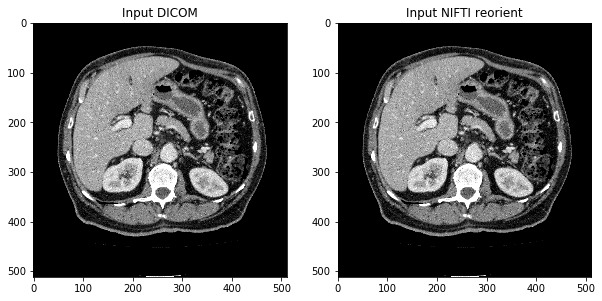

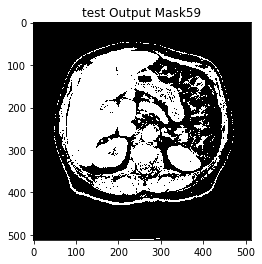

In [9]:
"""
img, ds, num_images, b, m = read_dicom_series(image_dir + os.path.sep, filepattern=dcm_pattern)  # rows, cols, slices
for slice_no in range(0, num_images):
    image_slice = img[..., slice_no]
    ds_slice = ds[slice_no]
    image_slice = image_slice.astype(IMG_DTYPE)  # np float
    image_slice = normalize_image_using_rescale_slope_intercept(image_slice, m, b)
    image_slice = byte_normalize_image(image_slice)
    image_slice = image_slice.astype(MASK_DTYPE)  
    write_dicom_mask_ex(image_slice, ds_slice, slice_no, output_dir)
"""   
img, ds, num_images, b, m = read_dicom_series("E:\\data\\CDor_3\\new_results\\test0\\PATIENT_DICOM", 
                                              filepattern=dcm_pattern)  # rows, cols, slices  

slice_no = num_images / 2
print(m, b)
img_slc = img[..., slice_no]
img_slc = img_slc.astype(IMG_DTYPE)
img_slc = normalize_image_using_rescale_slope_intercept(img_slc, m, b)
print("DICOM image stats after m/b: ")
stat(img_slc)

# NIFTI test
nifti_file = "E:\\data\\CDor_3\\new_results\\test0\\PATIENT_DICOM\\PATIENT_DICOM.nii"
nifti_base = Path(nifti_file).resolve().stem

proxy_img, hdr, num_images, b, m, axcodes = read_nifti_series(nifti_file)
# 888 move following into read_nifti
if (axcodes != ('R', 'A', 'S')) and (axcodes != ('L', 'A', 'S')):
    print("Input NIfti series is in unsupported orientation.  Please convert to RAS or LAS orientation:" + nifti_file)
    sys.exit(1)
# First voxel axis goes from right to Left; X
# Second voxel axis goes from posterior to Anterior; Z
# Third voxel axis goes from inferior to Superior.  Y
codes = ('P', 'L', 'S')  # nifti [y-axis, x-axis, ...]
labels = (('R','L'),('A','P'),('I','S')) # specifiy LPS for DICOM
orients = orientations.axcodes2ornt(codes, labels)
img_reorient = proxy_img.as_reoriented(orients)

img =  proxy_img.dataobj[..., slice_no, 0]
img2 = img_reorient.dataobj[..., slice_no, 0]

# check image
print("NIFIT image stats after m/b: ")
stat(img2)
print(img.shape)
img = img.astype(IMG_DTYPE)  # convert tp type expected by model

# check if rescale slope / intercept have been applied
img2 = img2.astype(IMG_DTYPE)  # convert to type expected by model

# apply W/L equally
win = 350
lev = 50
thresh_lo = float(lev) - 0.5 - float(win-1) / 2.0
thresh_hi = float(lev) - 0.5 + float(win-1) / 2.0
thresh_hi += 1.0  # +1 due to > sided test
img_slc = np.clip(img_slc, int(thresh_lo), int(thresh_hi))
img2 = np.clip(img2, int(thresh_lo), int(thresh_hi))
imshow(img_slc, img2, title=["Input DICOM","Input NIFTI reorient"])

# create a fake mask volume based on the loaded NIFTI series
# hdr, b, m, axcodes
mask = img_reorient
mask_data = mask.get_fdata()
mask_data = mask_data[...,0]  # 3D np []
for i in range(0, num_images):
    mask_slice = mask_data[..., i]
    mask_slice[mask_slice>1200] = 0
    thresh_lo = 0
    thresh_hi = 400
    mask_slice[mask_slice>thresh_hi] = 0
    mask_slice[mask_slice<thresh_lo] = 0
    mask_slice[mask_slice != 0] = 1
mask_data = mask_data.astype(np.uint16)
imshow(mask_data[..., slice_no], title="test Output Mask" + str(slice_no))

write_nifti_mask(img_reorient, axcodes, mask_data, "E:\\data\\CDor_3\\new_results\\test0\\PATIENT_DICOM\\nifti", nifti_base)